In [1]:
# To use in Google Colab or Kaggle Notebooks
!pip install datasets==2.14.5
!pip install torch==2.0.0
!pip install transformers==4.34.0
!pip install tqdm==4.66.1
!pip install tokenizers==0.14.1
!pip install pandas==2.0.3
!pip install scikit-learn==1.3.1
!pip install matplotlib==3.8.0
!pip install --upgrade numpy==1.22.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 12.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.9.0
    Uninstalling fsspec-2023.9.0:
      Successfully uninstalled fsspec-2023.9.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.2

In [2]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from enum import Enum
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [3]:
dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

Extracting data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
def filter_and_preprocess(data):
    """
    Filters a list of dictionaries by only including entries with services
    either "restaurant" or "hotel" and having only one service.

    Parameters:
    - data: list of dictionaries containing a "services" key, which is a list of services.

    Returns:
    - List of filtered dictionaries.
    """
    return [entry for entry in data if set(entry["services"]).issubset({"restaurant", "hotel"}) and len(entry["services"]) == 1]


train_data_filtered = filter_and_preprocess(train_data)
val_data_filtered = filter_and_preprocess(val_data)
test_data_filtered = filter_and_preprocess(test_data)

In [5]:
def toDataFrame(raw_data):
    # Initialize an empty list to store rows as dictionaries
    data = []

    # Loop through each dialogue in the training data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Loop through each turn in the dialogue
        for i in range(num_turns):

            # Extract the utterance and corresponding dialog act for this turn
            utterance = dialogue['turns']['utterance'][i]
            dialogue_act = dialogue['turns']['dialogue_acts'][i]['dialog_act']['act_type']

            # Append as a dictionary to the data list
            data.append({'Utterance': utterance, 'DialogueAct': dialogue_act})

    # Save data as pandas df
    df = pd.DataFrame(data)

    # Separate features and labels
    X = df['Utterance']
    Y = df['DialogueAct']
    
    return X, Y
        
X_train, Y_train = toDataFrame(train_data_filtered)
X_val, Y_val = toDataFrame(val_data_filtered)
X_test, Y_test = toDataFrame(test_data_filtered)

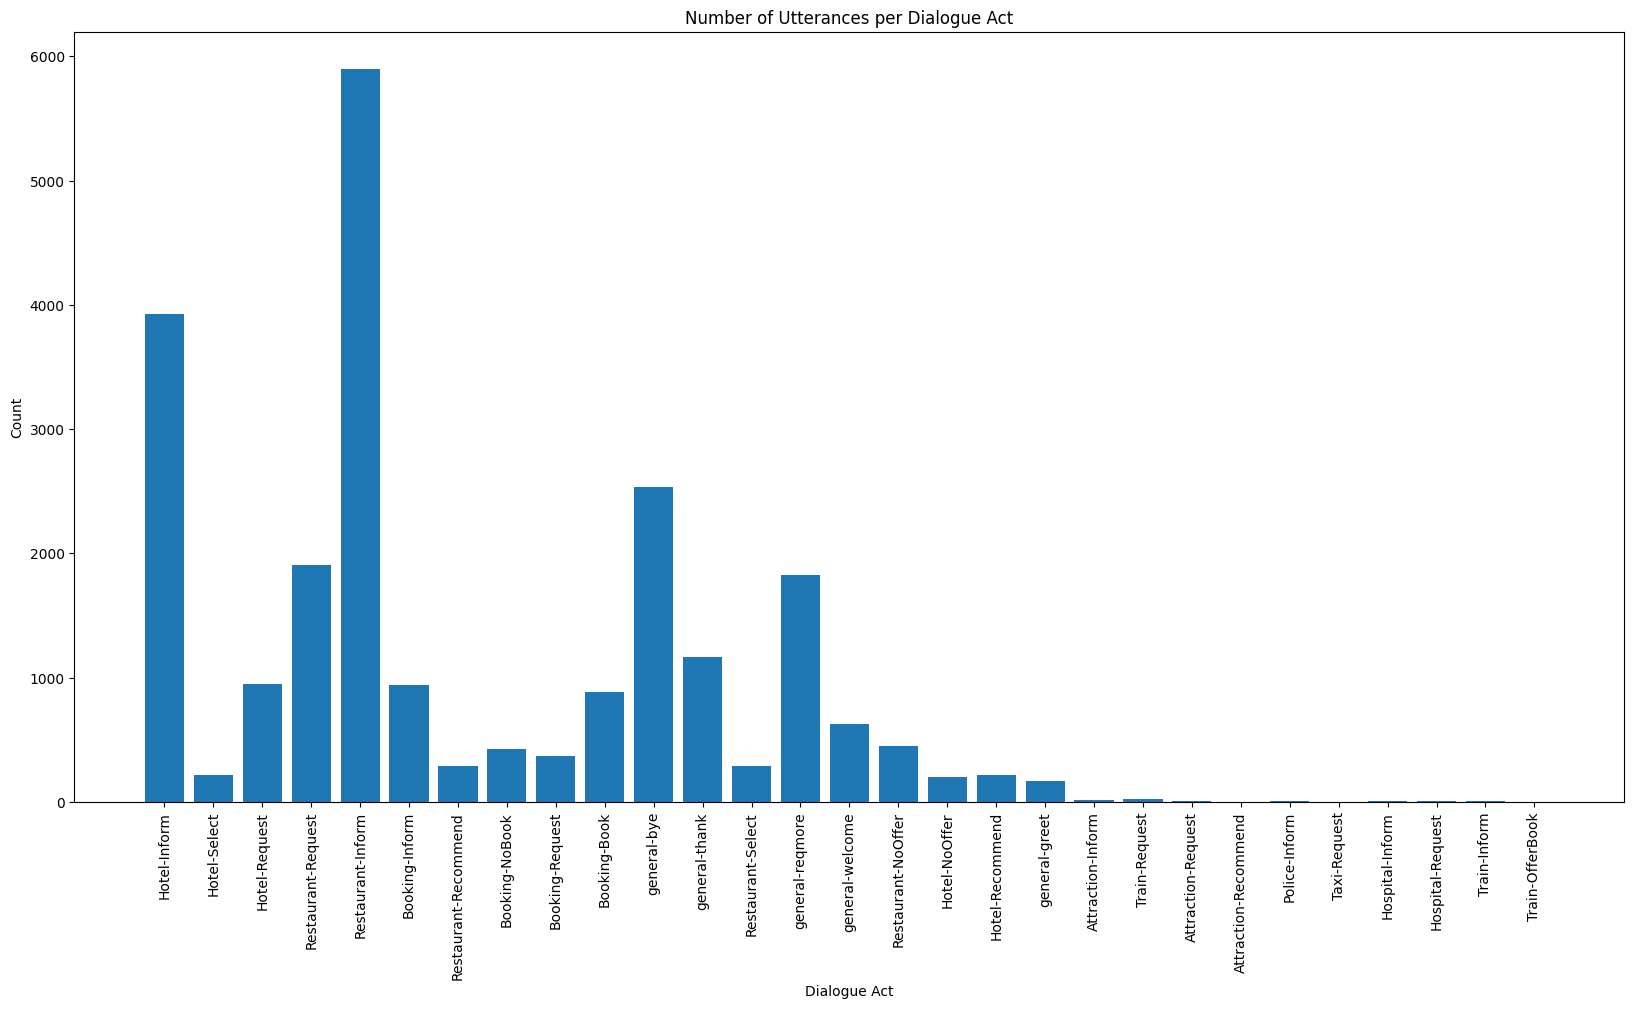

[('Attraction-Recommend', 1), ('Taxi-Request', 1), ('Train-OfferBook', 3), ('Attraction-Request', 5), ('Hospital-Request', 5), ('Police-Inform', 7), ('Hospital-Inform', 7), ('Train-Inform', 10), ('Attraction-Inform', 12), ('Train-Request', 26)]


In [6]:
# Generate a histogram of the number of utterances per dialogue act, knowing that there can be multiple dialogue acts per utterance. 
# To deal with this, we count as a separate utterance each time a dialogue act is present in an utterance, instead of counting more than one
# dialogue act per utterance.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_train:
        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:
            
            # If the dialogue act is already in the dictionary, increment its count by 1
            if dialogue_act in counts:
                counts[dialogue_act] += 1
            
            # If the dialogue act is not already in the dictionary, set its count to 1
            else:
                counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Utterances per Dialogue Act')
plt.show()

# Bottom 10 dialogue acts
sorted_counts = sorted(counts.items(), key=lambda item: item[1])
print(sorted_counts[:10])


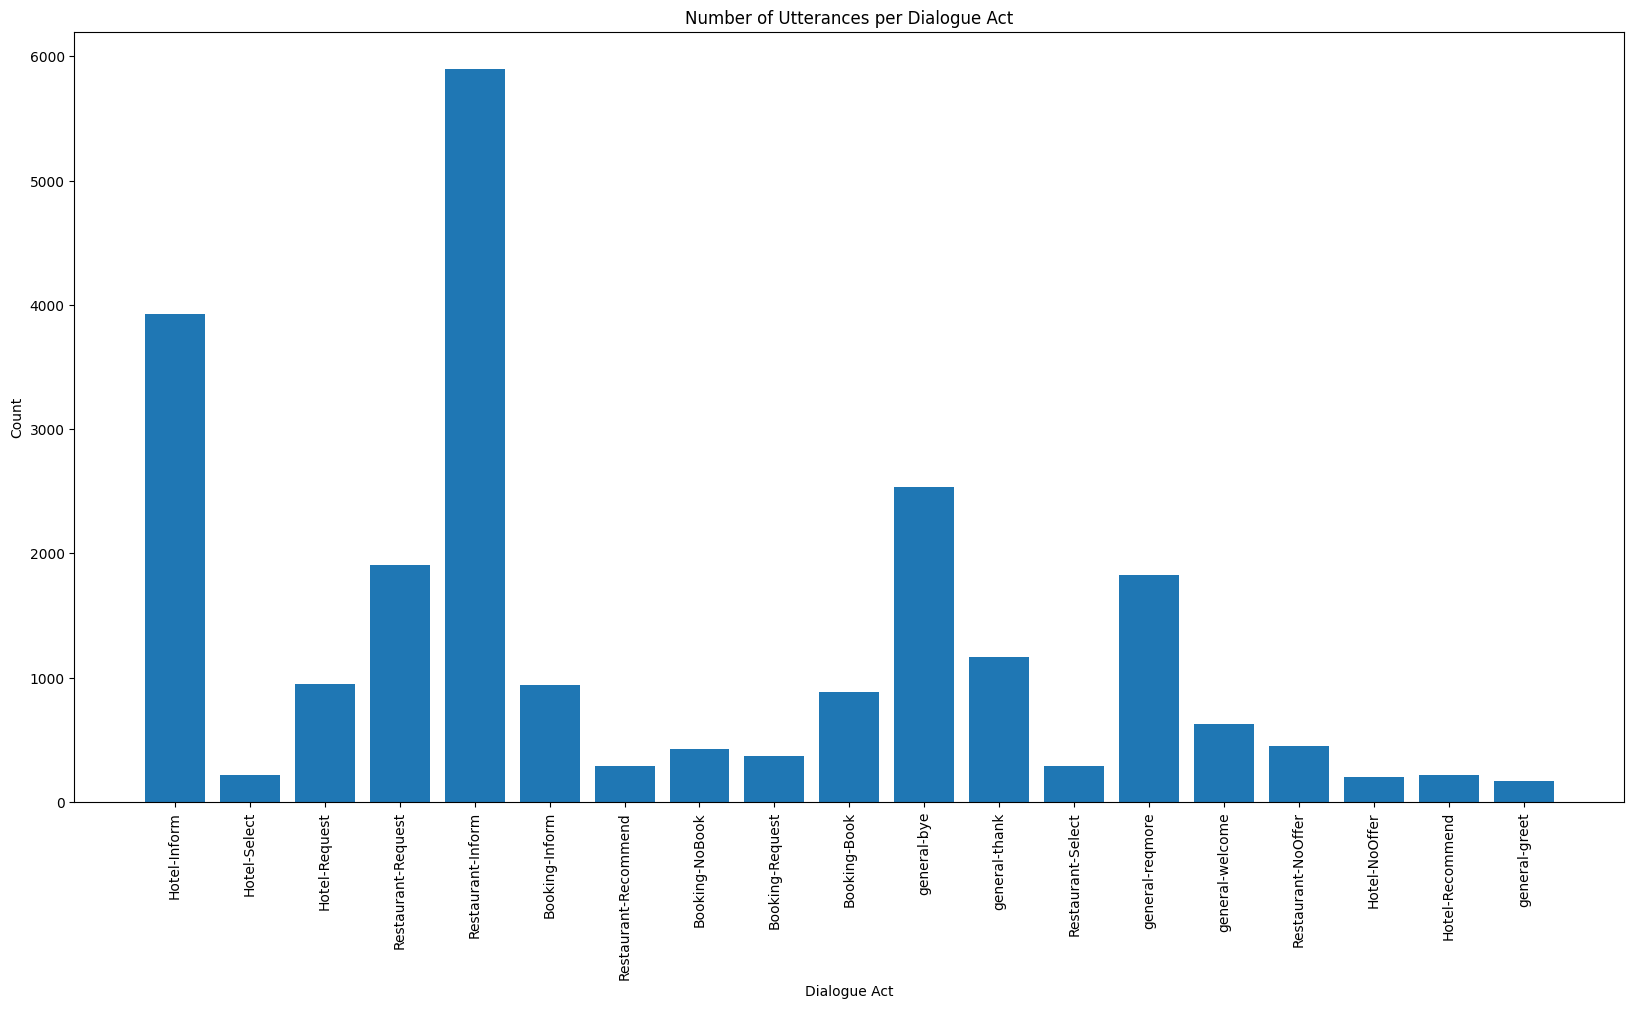

In [7]:
# For every utterance that has multiple dialog acts, remove only the dialog acts that appear in this list (the strings):
#  [('Attraction-Recommend', 1), ('Taxi-Request', 1), ('Train-OfferBook', 3), ('Attraction-Request', 5), ('Hospital-Request', 5), ('Police-Inform', 7), ('Hospital-Inform', 7), ('Train-Inform', 10), ('Attraction-Inform', 12), ('Train-Request', 26)]
# Generalize the previous procedure in a function
def prune_data(Y):
    """
    Prunes the data to exclude the bottom 10 dialogue acts.

    Parameters:
    - Y: list of lists of dialogue acts.

    Returns:
    - Pruned list of lists of dialogue acts.
    """
    # Initialize an empty list to store the pruned data
    Y_pruned = []

    # Loop through each dialogue act array in the data
    for dialogue_act_array in Y:

        # Initialize an empty list to store the pruned dialogue acts for this utterance
        pruned_dialogue_act_array = []

        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:

            # If the dialogue act is not in the list of bottom 10 dialogue acts, append it to the pruned dialogue act array
            if dialogue_act not in ['Attraction-Recommend', 'Taxi-Request', 'Train-OfferBook', 'Attraction-Request', 'Hospital-Request', 'Police-Inform', 'Hospital-Inform', 'Train-Inform', 'Attraction-Inform', 'Train-Request']:
                pruned_dialogue_act_array.append(dialogue_act)

        # Append the pruned dialogue act array to the pruned data
        Y_pruned.append(pruned_dialogue_act_array)
    
    return Y_pruned

def prune_empty_dialogue_acts(X, Y):
    """
    Prunes the data to exclude utterances with no dialogue acts.

    Parameters:
    - X: list of utterances.
    - Y: list of lists of dialogue acts.

    Returns:
    - Pruned lists of utterances and dialogue acts.
    """
    # Initialize empty lists to store the pruned data
    X_pruned = []
    Y_pruned = []

    # Loop through each utterance and corresponding dialogue act array in the data
    for utterance, dialogue_act_array in zip(X, Y):

        # If the dialogue act array is not empty, append the utterance and dialogue act array to the pruned data
        if len(dialogue_act_array) > 0:
            X_pruned.append(utterance)
            Y_pruned.append(dialogue_act_array)
    
    return X_pruned, Y_pruned


# Prune the training, validation, and test data
Y_pruned_train = prune_data(Y_train)
Y_pruned_val = prune_data(Y_val)
Y_pruned_test = prune_data(Y_test)

# Prune empty dialogue acts for training, validation, and test data
X_pruned_train, Y_pruned_train = prune_empty_dialogue_acts(X_train, Y_pruned_train)
X_pruned_val, Y_pruned_val = prune_empty_dialogue_acts(X_val, Y_pruned_val)
X_pruned_test, Y_pruned_test = prune_empty_dialogue_acts(X_test, Y_pruned_test)

# Generate a histogram of the number of utterances per dialogue act, knowing that there can be multiple dialogue acts per utterance.
# To deal with this, we count as a separate utterance each time a dialogue act is present in an utterance, instead of counting more than one
# dialogue act per utterance.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_pruned_train:
    # Loop through each dialogue act in the dialogue act array
    for dialogue_act in dialogue_act_array:
        
        # If the dialogue act is already in the dictionary, increment its count by 1
        if dialogue_act in counts:
            counts[dialogue_act] += 1
        
        # If the dialogue act is not already in the dictionary, set its count to 1
        else:
            counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Utterances per Dialogue Act')
plt.show()

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer


# Initialize a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer object on the training data
mlb.fit(Y_pruned_train)

# Transform the training, validation, and test data
Y_encoded_train = mlb.transform(Y_pruned_train)
Y_encoded_val = mlb.transform(Y_pruned_val)
Y_encoded_test = mlb.transform(Y_pruned_test)

# Print the shape of the encoded training, validation, and test data
print(Y_encoded_train.shape)
print(Y_encoded_val.shape)
print(Y_encoded_test.shape)

# Print the classes
print(mlb.classes_)
# Print the number of classes
print(len(mlb.classes_))

# Print the first 10 encoded training labels
print(Y_encoded_train[:10])

# Print the first 10 decoded training labels
print(mlb.inverse_transform(Y_encoded_train[:10]))

(17749, 19)
(1120, 19)
(1377, 19)
['Booking-Book' 'Booking-Inform' 'Booking-NoBook' 'Booking-Request'
 'Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Recommend' 'Hotel-Request'
 'Hotel-Select' 'Restaurant-Inform' 'Restaurant-NoOffer'
 'Restaurant-Recommend' 'Restaurant-Request' 'Restaurant-Select'
 'general-bye' 'general-greet' 'general-reqmore' 'general-thank'
 'general-welcome']
19
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[('Hotel-Inform',), ('Hotel-Inform', 'Hotel-Select'), ('Hotel-Inform',), ('Hotel-Request', 'Restaurant-Request'), ('Hotel-Inform', 'Restaurant-Inform'), ('Booking-Inform', 'Hotel-Inform', 'Restaurant-Recommend')

In [9]:
# Bert Models Enumeration
class BertModelsEnum(str, Enum):
    distilbert_base_uncased = 'distilbert-base-uncased'
    distilbert_base_cased = 'distilbert-base-cased'

bert_model_type = BertModelsEnum.distilbert_base_uncased.value
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_type)
def tokenize_data(X, Y):
    input_encoded = []
    attention_masks = []
    labels = []
    for x,y in zip(X,Y):
        encoded = tokenizer.encode_plus(
            x, 
            add_special_tokens=True, 
            max_length=256, 
            padding='max_length', 
            truncation=True, 
            return_attention_mask=True)
        input_encoded.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(y)
    return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)

train_input, train_masks, train_labels = tokenize_data(X_pruned_train, Y_encoded_train)
val_input, val_masks, val_labels = tokenize_data(X_pruned_val, Y_encoded_val)
test_input, test_masks, test_labels = tokenize_data(X_pruned_test, Y_encoded_test)

/tmp/ipykernel_32/3022322944.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)


In [10]:
batch_size = 64 # Adjust based on GPU memory requirements
num_workers = 6 # Adjust based on the number of CPU cores

train_data = TensorDataset(train_input, train_masks, train_labels)
val_data = TensorDataset(val_input, val_masks, val_labels)
test_data = TensorDataset(test_input, test_masks, test_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_type)
        self.fc = nn.Linear(768, len(mlb.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] # selects the [CLS] token position.
        logits = self.fc(cls_output)
        return logits

In [12]:
class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf')
    ):
        self.smallest_valid_loss = smallest_valid_loss
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [16]:
model = BertClassifier()
model = model.to(device)
 
optimizer = optim.Adam(model.parameters(), lr=5e-6)
criterion = nn.BCEWithLogitsLoss()

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=20)

save_best_model_instance = SaveModelWithBestValLoss()

# For storing training and validation loss
train_losses = []
val_losses = []

lrs = []
for epoch in range(5):
    model.train()
    
    # Initialize tqdm progress bar
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
    train_loss = 0.0
    for batch in train_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update training loss
        train_loss += loss.item()
        train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    with torch.no_grad():
        for batch in val_bar:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels.float())
            
            val_loss += loss.item()
            val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

Validation Epoch 0: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.088]


Epoch 0, Training Loss: 0.3929326489246149, Validation Loss: 0.25738314125272965
Saving best model for epoch 1, with new best validation loss: 0.25738314125272965



Validation Epoch 1: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s, validation_loss=0.075]


Epoch 1, Training Loss: 0.23234143740624832, Validation Loss: 0.2141830606593026
Saving best model for epoch 2, with new best validation loss: 0.2141830606593026



Validation Epoch 2: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s, validation_loss=0.067]


Epoch 2, Training Loss: 0.19957456469750232, Validation Loss: 0.1865484822127554
Saving best model for epoch 3, with new best validation loss: 0.1865484822127554



Validation Epoch 3: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s, validation_loss=0.059]


Epoch 3, Training Loss: 0.17440653737071607, Validation Loss: 0.1642826646566391
Saving best model for epoch 4, with new best validation loss: 0.1642826646566391



Validation Epoch 4: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, validation_loss=0.055]


Epoch 4, Training Loss: 0.1561627759457492, Validation Loss: 0.1500077173113823
Saving best model for epoch 5, with new best validation loss: 0.1500077173113823



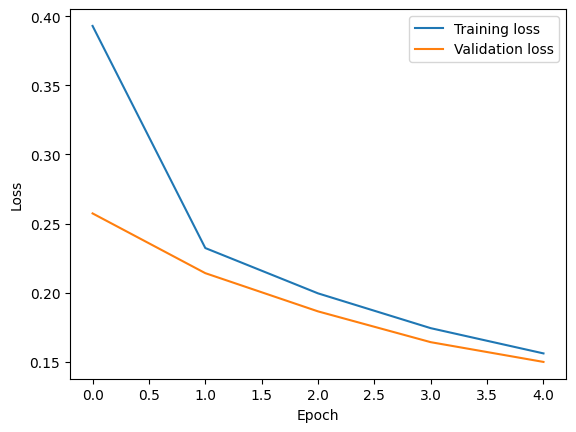

In [17]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
# build the model, without loading the pre-trained weights or fine-tune layers
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

In [30]:
all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for validation
    val_bar = tqdm(test_loader, desc='Test')

    for batch in val_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids, attention_mask)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

Test:   0%|          | 0/22 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Test: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s]


In [34]:
print(all_preds)

[array([-2.3720195, -1.8983163, -2.4429138, -2.3246257,  1.5670158,
       -2.7484927, -2.1392858, -1.9787502, -2.308628 , -1.2359232,
       -2.9282699, -2.6758707, -2.642475 , -2.4599802, -3.039433 ,
       -2.7236588, -2.7533958, -2.8384178, -3.0438354], dtype=float32), array([-2.5009632 , -1.3397148 , -1.5497037 , -2.195072  ,  0.07761375,
       -2.2337296 , -2.3440042 , -1.8921477 , -2.3674314 , -2.407976  ,
       -2.0252447 , -2.9236846 , -1.9885248 , -2.69659   , -3.1731226 ,
       -2.75838   , -0.92936224, -2.5840025 , -2.8292484 ], dtype=float32), array([-2.8758025 , -2.5296443 , -2.8210824 , -2.4459126 ,  0.4232968 ,
       -2.8538172 , -2.3739257 , -2.2506802 , -2.3331444 , -0.75938606,
       -3.0072057 , -2.742694  , -2.526317  , -2.4168682 , -2.8215168 ,
       -2.811623  , -2.8902092 , -2.6688156 , -3.17251   ], dtype=float32), array([-2.0413532, -1.2611204, -2.4524033, -2.412514 ,  1.0786979,
       -2.8324385, -2.1673553, -1.8328565, -2.1836815, -1.310052 ,
       -

In [27]:
from sklearn.metrics import classification_report
import numpy as np
pred = np.argmax(all_preds, axis=1)
print("None ", classification_report(all_labels, pred))  



AxisError: axis 1 is out of bounds for array of dimension 1